In [84]:
# 각 시스템별 지정 이벤트를 모아 하나의 DataFrame으로 만들기 (timestamp 기준 정렬, 이전 event와 시간 차, system 이름 매핑)
import pandas as pd

all_event_dfs = []

for i in range(1, 13):
    pid = f"P{i}"  # 원하는 사용자로 변경 가능
    df = pd.read_csv(f'csv/{pid}_filtered.csv')

    # participant_info에서 system order 읽기
    info_df = pd.read_csv('participant_info.csv')
    row = info_df[info_df['participants'] == pid]
    order = row['system order'].values[0].replace(' ', '').split(',')
    system1_name = 'Baseline'
    system2_name = 'OOPT'
    system_names = {}
    if order == ['1','2']:
        system_names[1] = system1_name
        system_names[2] = system2_name
    elif order == ['2','1']:
        system_names[1] = system2_name
        system_names[2] = system1_name

    # 시스템 구간 나누기
    system_indices = df[df['event'] == 'system_survey_completed'].index.tolist()
    system_ranges = []
    prev_idx = 0
    for idx in system_indices:
        system_ranges.append((prev_idx, idx))
        prev_idx = idx + 1
    if prev_idx < len(df):
        system_ranges.append((prev_idx, len(df)-1))

    # 추출할 이벤트 목록 정의
    events_to_extract = [
        'layout_board.new_box_initiated',
        'baselineboard.node.add.instance',
        'layout_board.new_box_positioned',
        'class_detail_opened',
        'instance.create_from_class.started',
        'baselineboard.node.edit',
        'instance.edit.started',
        'api.generate_scene_graph_to_text.started',
        'api.generate_text_to_graph.started',
        'object_node.extract.confirmed',
        'object_clicked'
    ]

    # 결과를 담을 리스트
    event_rows_list = []

    for sys_num, (start, end) in enumerate(system_ranges):
        sys_df = df.iloc[start:end+1]
        for event in events_to_extract:
            event_rows = sys_df[sys_df['event'] == event].copy()
            if not event_rows.empty:
                event_rows['system'] = sys_num + 1
                event_rows['system_name'] = system_names.get(sys_num+1, f'System {sys_num+1}')
                event_rows_list.append(event_rows)

    # 하나의 DataFrame으로 합치고 timestamp 기준 정렬
    result_df = pd.concat(event_rows_list, ignore_index=True)
    result_df = result_df.sort_values('timestamp').reset_index(drop=True)

    # 이전 event와의 시간 차 계산
    result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])
    result_df['delta_sec'] = result_df['timestamp'].diff().dt.total_seconds()
    result_df.loc[0, 'delta_sec'] = None  # 첫 행은 이전 event가 없으므로 None 처리

    print("Calculated Delta Time")

    # 주요 event 쌍별 시간 차 계산 및 이름 부여 (연속 row 기준)
    import pandas as pd

    # result_df가 이미 생성되어 있다고 가정
    event_pairs = [
        # (start_event, end_event, system_name, label)
        ('layout_board.new_box_positioned', 'api.generate_text_to_graph.started', 'OOPT', 'Init-OOPT'),
        ('class_detail_opened', 'instance.create_from_class.started', 'OOPT', 'Init-OOPT'),
        ('class_detail_opened', 'api.generate_scene_graph_to_text.started', 'OOPT', 'Init-OOPT'),
        ('instance.edit.started', 'api.generate_text_to_graph.started', 'OOPT', 'Edit-OOPT'),
        ('instance.edit.started', 'api.generate_scene_graph_to_text.started', 'OOPT', 'Edit-OOPT'),
        ('layout_board.new_box_initiated', 'baselineboard.node.add.instance', 'Baseline', 'Init-Baseline'),
        # Baseline Prompt edit: 직전 event - baselineboard.node.edit
        # 아래에서 따로 처리
    ]

    results = []

    for i in range(len(result_df)-1):
        row1 = result_df.iloc[i]
        row2 = result_df.iloc[i+1]
        for start_event, end_event, system_name, label in event_pairs:
            if (row1['event'] == start_event and row2['event'] == end_event and
                row1['system_name'] == system_name and row2['system_name'] == system_name):
                delta = (row2['timestamp'] - row1['timestamp']).total_seconds()
                results.append({
                    'system_name': system_name,
                    'label': label,
                    'start_event': start_event,
                    'end_event': end_event,
                    'start_time': row1['timestamp'],
                    'end_time': row2['timestamp'],
                    'delta_sec': delta
                })

    # Baseline Prompt edit (직전 event - baselineboard.node.edit)
    for i in range(1, len(result_df)):
        row1 = result_df.iloc[i-1]
        row2 = result_df.iloc[i]
        if (row2['event'] == 'baselineboard.node.edit' and row2['system_name'] == 'Baseline'):
            delta = (row2['timestamp'] - row1['timestamp']).total_seconds()
            results.append({
                'system_name': 'Baseline',
                'label': 'Edit-Baseline',
                'start_event': row1['event'],
                'end_event': 'baselineboard.node.edit',
                'start_time': row1['timestamp'],
                'end_time': row2['timestamp'],
                'delta_sec': delta
            })

    # 결과 DataFrame 생성 및 출력
    summary_df = pd.DataFrame(results)
    summary_df[['system_name', 'label', 'start_event', 'end_event', 'delta_sec']]

    summary_df.to_csv(f'csv/{pid}_event_durations.csv', index=False)
    
    # summary_df가 이미 생성되어 있다고 가정
    stats = summary_df.groupby('label')['delta_sec'].agg(['mean', 'std', 'count']).reset_index()
    print(stats)

    all_event_dfs.append(summary_df)

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/696523858.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/696523858.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/696523858.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])
/var

Calculated Delta Time
           label       mean        std  count
0  Edit-Baseline  44.333333  44.398761      9
1      Edit-OOPT  18.500000  31.927475     12
2  Init-Baseline  72.800000  37.399198      5
3      Init-OOPT  74.400000  28.728035      5
Calculated Delta Time
           label       mean        std  count
0  Edit-Baseline  34.444444  43.789585      9
1      Edit-OOPT   7.000000   2.683282      6
2  Init-Baseline  22.800000   9.576012      5
3      Init-OOPT  13.909091  11.121641     11
Calculated Delta Time
           label       mean        std  count
0  Edit-Baseline  50.888889  31.793245     18
1      Edit-OOPT  28.650000  32.249480     20
2  Init-Baseline  12.000000  13.366625      4
3      Init-OOPT   6.750000   5.775564      8
Calculated Delta Time
           label        mean         std  count
0  Edit-Baseline  108.428571  159.791382      7
1      Edit-OOPT   34.000000   18.927493      9
2  Init-Baseline   52.400000   24.754798      5
3      Init-OOPT  183.000000  

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/696523858.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df['timestamp'] = pd.to_datetime(result_df['timestamp'])


In [85]:
# -*- coding: utf-8 -*-
import os
from pathlib import Path
import pandas as pd

BASE_DIR = Path("csv")  # 로그/CSV 폴더
PARTICIPANTS = [f"P{i}" for i in range(1, 13)]  # 필요 시 수정

def robust_agg(df, value_col="delta_sec"):
    """견고한 기술통계 집계 함수"""
    s = pd.to_numeric(df[value_col], errors="coerce").dropna()
    if s.empty:
        return pd.Series({
            "count": 0, "mean": None, "std": None, "median": None,
            "p25": None, "p75": None, "min": None, "max": None, "sum": None
        })
    return pd.Series({
        "count": int(s.count()),
        "mean": s.mean(),
        "std": s.std(ddof=1) if s.count() > 1 else 0.0,
        "median": s.median(),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
        "min": s.min(),
        "max": s.max(),
        "sum": s.sum(),
    })

def compute_all_stats():
    info_df = pd.read_csv("participant_info.csv")
    all_event_dfs = []  # <- 여기 모아서 전역 통계 산출

    for pid in PARTICIPANTS:
        csv_path = BASE_DIR / f"{pid}_filtered.csv"
        if not csv_path.exists():
            print(f"[WARN] Missing file for {pid}: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        # participant_info에서 system order 읽기
        row = info_df[info_df["participants"] == pid]
        if row.empty:
            print(f"[WARN] Missing participant_info for {pid}")
            continue

        order = row["system order"].values[0].replace(" ", "").split(",")
        system1_name, system2_name = "Baseline", "OOPT"
        system_names = {}
        if order == ["1", "2"]:
            system_names[1] = system1_name
            system_names[2] = system2_name
        elif order == ["2", "1"]:
            system_names[1] = system2_name
            system_names[2] = system1_name
        else:
            # 예외: 정의되지 않은 순서면 기본 매핑
            system_names[1] = "System 1"
            system_names[2] = "System 2"

        # 시스템 구간 나누기
        system_indices = df[df["event"] == "system_survey_completed"].index.tolist()
        system_ranges = []
        prev_idx = 0
        for idx in system_indices:
            system_ranges.append((prev_idx, idx))
            prev_idx = idx + 1
        if prev_idx < len(df):
            system_ranges.append((prev_idx, len(df) - 1))

        # 추출할 이벤트 목록
        events_to_extract = [
            "layout_board.new_box_initiated",
            "baselineboard.node.add.instance",
            "layout_board.new_box_positioned",
            "class_detail_opened",
            "instance.create_from_class.started",
            "baselineboard.node.edit",
            "instance.edit.started",
            "api.generate_scene_graph_to_text.started",
            "api.generate_text_to_graph.started",
            "object_node.extract.confirmed",
            "object_clicked",
        ]

        # 결과를 담을 리스트
        event_rows_list = []

        for sys_num, (start, end) in enumerate(system_ranges):
            sys_df = df.iloc[start : end + 1]
            for ev in events_to_extract:
                event_rows = sys_df[sys_df["event"] == ev].copy()
                if not event_rows.empty:
                    event_rows["system"] = sys_num + 1
                    event_rows["system_name"] = system_names.get(sys_num + 1, f"System {sys_num+1}")
                    event_rows_list.append(event_rows)

        if not event_rows_list:
            print(f"[WARN] No target events found for {pid}")
            continue

        # 하나의 DataFrame으로 합치고 timestamp 기준 정렬
        result_df = pd.concat(event_rows_list, ignore_index=True)
        result_df = result_df.sort_values("timestamp").reset_index(drop=True)

        # 이전 event와의 시간 차 계산
        result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
        # 정렬 후 다시 인덱스
        result_df = result_df.sort_values("timestamp").reset_index(drop=True)
        result_df["delta_sec"] = result_df["timestamp"].diff().dt.total_seconds()
        if len(result_df) > 0:
            result_df.loc[0, "delta_sec"] = None

        # 이벤트 쌍 정의
        event_pairs = [
            # (start_event, end_event, system_name, label)
            ("layout_board.new_box_positioned", "api.generate_text_to_graph.started", "OOPT", "Init-OOPT"),
            ("class_detail_opened", "instance.create_from_class.started", "OOPT", "Init-OOPT"),
            ("class_detail_opened", "api.generate_scene_graph_to_text.started", "OOPT", "Init-OOPT"),
            ("instance.edit.started", "api.generate_text_to_graph.started", "OOPT", "Edit-OOPT"),
            ("instance.edit.started", "api.generate_scene_graph_to_text.started", "OOPT", "Edit-OOPT"),
            ("layout_board.new_box_initiated", "baselineboard.node.add.instance", "Baseline", "Init-Baseline"),
            # Baseline Prompt edit: 직전 event - baselineboard.node.edit (아래 별도 처리)
        ]

        results = []

        # 연속 행 기준 쌍 매칭
        for i in range(len(result_df) - 1):
            row1 = result_df.iloc[i]
            row2 = result_df.iloc[i + 1]
            for start_event, end_event, sys_name, label in event_pairs:
                if (
                    row1["event"] == start_event
                    and row2["event"] == end_event
                    and row1["system_name"] == sys_name
                    and row2["system_name"] == sys_name
                ):
                    if pd.notnull(row1["timestamp"]) and pd.notnull(row2["timestamp"]):
                        delta = (row2["timestamp"] - row1["timestamp"]).total_seconds()
                        results.append(
                            {
                                "pid": pid,
                                "system_name": sys_name,
                                "label": label,
                                "start_event": start_event,
                                "end_event": end_event,
                                "start_time": row1["timestamp"],
                                "end_time": row2["timestamp"],
                                "delta_sec": delta,
                            }
                        )

        # Baseline Prompt edit (직전 event → baselineboard.node.edit)
        for i in range(1, len(result_df)):
            row1 = result_df.iloc[i - 1]
            row2 = result_df.iloc[i]
            if row2["event"] == "baselineboard.node.edit" and row2["system_name"] == "Baseline":
                if pd.notnull(row1["timestamp"]) and pd.notnull(row2["timestamp"]):
                    delta = (row2["timestamp"] - row1["timestamp"]).total_seconds()
                    results.append(
                        {
                            "pid": pid,
                            "system_name": "Baseline",
                            "label": "Edit-Baseline",
                            "start_event": row1["event"],
                            "end_event": "baselineboard.node.edit",
                            "start_time": row1["timestamp"],
                            "end_time": row2["timestamp"],
                            "delta_sec": delta,
                        }
                    )

        summary_df = pd.DataFrame(results)
        # 참가자별 결과 CSV(개별) 저장
        out_path = BASE_DIR / f"{pid}_event_durations.csv"
        summary_df.to_csv(out_path, index=False)
        print(f"[OK] Saved per-participant durations: {out_path}")

        all_event_dfs.append(summary_df)

    # ===== 모든 참가자 집계 =====
    if not all_event_dfs:
        print("[WARN] No participant summaries gathered. Nothing to aggregate.")
        return

    all_events_df = pd.concat(all_event_dfs, ignore_index=True)

    # 정리: 숫자/결측치/음수 처리
    all_events_df["delta_sec"] = pd.to_numeric(all_events_df["delta_sec"], errors="coerce")
    all_events_df = all_events_df.dropna(subset=["delta_sec"])
    all_events_df = all_events_df[all_events_df["delta_sec"] >= 0]  # 음수 제거(로그 꼬임 방지)

    # --- (옵션) 아웃라이어 컷: 상위 99퍼센타일 제거 (필요 시 True로) ---
    APPLY_OUTLIER_CUT = False
    if APPLY_OUTLIER_CUT and not all_events_df.empty:
        cutoff = all_events_df["delta_sec"].quantile(0.99)
        all_events_df = all_events_df[all_events_df["delta_sec"] <= cutoff]

    # 저장: 전 참가자 원천 표
    all_path = BASE_DIR / "all_participants_event_durations.csv"
    all_events_df.to_csv(all_path, index=False)
    print(f"[OK] Saved all-participants merged durations: {all_path}")

    # 통계 1) 라벨 단위 전체 통계
    stats_overall = (
        all_events_df
        .groupby(["label"])
        .apply(lambda g: robust_agg(g, "delta_sec"))
        .reset_index()
    )
    stats_overall_path = BASE_DIR / "event_duration_stats_overall.csv"
    stats_overall.to_csv(stats_overall_path, index=False)
    print(f"[OK] Saved overall stats: {stats_overall_path}")

    # # 통계 2) 시스템별 + 라벨
    # stats_by_sys = (
    #     all_events_df
    #     .groupby(["system_name", "label"])
    #     .apply(lambda g: robust_agg(g, "delta_sec"))
    #     .reset_index()
    #     .sort_values(["system_name", "label"])
    # )
    # stats_by_sys_path = BASE_DIR / "event_duration_stats_by_system.csv"
    # stats_by_sys.to_csv(stats_by_sys_path, index=False)
    # print(f"[OK] Saved by-system stats: {stats_by_sys_path}")

    # # 통계 3) Pid별 + 라벨 (사람별 분포 확인용)
    # stats_by_pid = (
    #     all_events_df
    #     .groupby(["pid", "label"])
    #     .apply(lambda g: robust_agg(g, "delta_sec"))
    #     .reset_index()
    #     .sort_values(["pid", "label"])
    # )
    # stats_by_pid_path = BASE_DIR / "event_duration_stats_by_pid.csv"
    # stats_by_pid.to_csv(stats_by_pid_path, index=False)
    # print(f"[OK] Saved by-pid stats: {stats_by_pid_path}")

    print("\n[SUMMARY]")
    print("Overall:\n", stats_overall.head())
    # print("\nBy system:\n", stats_by_sys.head())
    # print("\nBy pid:\n", stats_by_pid.head())

if __name__ == "__main__":
    compute_all_stats()


[OK] Saved per-participant durations: csv/P1_event_durations.csv
[OK] Saved per-participant durations: csv/P2_event_durations.csv
[OK] Saved per-participant durations: csv/P3_event_durations.csv
[OK] Saved per-participant durations: csv/P4_event_durations.csv
[OK] Saved per-participant durations: csv/P5_event_durations.csv
[OK] Saved per-participant durations: csv/P6_event_durations.csv
[OK] Saved per-participant durations: csv/P7_event_durations.csv
[OK] Saved per-participant durations: csv/P8_event_durations.csv
[OK] Saved per-participant durations: csv/P9_event_durations.csv
[OK] Saved per-participant durations: csv/P10_event_durations.csv
[OK] Saved per-participant durations: csv/P11_event_durations.csv
[OK] Saved per-participant durations: csv/P12_event_durations.csv
[OK] Saved all-participants merged durations: csv/all_participants_event_durations.csv
[OK] Saved overall stats: csv/event_duration_stats_overall.csv

[SUMMARY]
Overall:
            label  count       mean        std 

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/1942200040.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/1942200040.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/1942200040.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/3824776691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


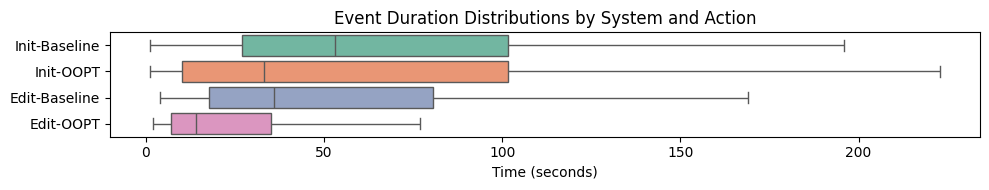

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 데이터 불러오기 ---
df = pd.read_csv("csv/all_participants_event_durations.csv")

# 필요한 label만 추출
target_labels = ["Init-OOPT", "Init-Baseline", "Edit-OOPT", "Edit-Baseline"]
df = df[df["label"].isin(target_labels)]

# label 순서 지정
label_order = ["Init-Baseline", "Init-OOPT", "Edit-Baseline", "Edit-OOPT"]

# --- 시각화 ---
plt.figure(figsize=(10, 2))

# x축 = delta_sec, y축 = label
sns.boxplot(
    data=df,
    x="delta_sec",
    y="label",
    order=label_order,
    orient="h",
    showfliers=False,  # 극단치 표시 안할 경우
    palette="Set2"
)

# 분포 모양을 좀 더 보고 싶으면 violinplot 추가 (투명도)
# sns.violinplot(
#     data=df,
#     x="delta_sec",
#     y="label",
#     order=label_order,
#     orient="h",
#     inner=None,
#     color="0.9",
#     alpha=0.3
# )

plt.xlabel("Time (seconds)")
plt.ylabel("")
plt.title("Event Duration Distributions by System and Action")
plt.tight_layout()
plt.show()


In [75]:
from scipy import stats

# 참가자별 평균값으로 요약 (반복측정에 맞게)
pivot_df = df.pivot_table(index="pid", columns="label", values="delta_sec", aggfunc="mean").dropna()

stat, p = stats.friedmanchisquare(
    pivot_df["Init-Baseline"],
    pivot_df["Init-OOPT"],
    pivot_df["Edit-Baseline"],
    pivot_df["Edit-OOPT"]
)
print("Friedman test:", stat, p)


Friedman test: 16.309090909090912 0.0009799541671433936


In [76]:
# Init: Baseline vs OOPT
baseline = df[df["label"]=="Init-Baseline"]["delta_sec"].dropna()
oopt = df[df["label"]=="Init-OOPT"]["delta_sec"].dropna()

u_stat, p_val = stats.mannwhitneyu(baseline, oopt, alternative="two-sided")
print("Init Baseline vs OOPT Mann-Whitney U:", u_stat, p_val)

# Edit: Baseline vs OOPT
baseline = df[df["label"]=="Edit-Baseline"]["delta_sec"].dropna()
oopt = df[df["label"]=="Edit-OOPT"]["delta_sec"].dropna()

u_stat, p_val = stats.mannwhitneyu(baseline, oopt, alternative="two-sided")
print("Edit Baseline vs OOPT Mann-Whitney U:", u_stat, p_val)


Init Baseline vs OOPT Mann-Whitney U: 2485.5 0.12025174719067934
Edit Baseline vs OOPT Mann-Whitney U: 8476.0 9.76377623966982e-07


In [83]:
# -*- coding: utf-8 -*-
import os
from pathlib import Path
import pandas as pd

BASE_DIR = Path("csv")  # 로그/CSV 폴더
PARTICIPANTS = [f"P{i}" for i in range(1, 13)]  # 필요 시 수정

def robust_agg(df, value_col="delta_sec"):
    """견고한 기술통계 집계 함수"""
    s = pd.to_numeric(df[value_col], errors="coerce").dropna()
    if s.empty:
        return pd.Series({
            "count": 0, "mean": None, "std": None, "median": None,
            "p25": None, "p75": None, "min": None, "max": None, "sum": None
        })
    return pd.Series({
        "count": int(s.count()),
        "mean": s.mean(),
        "std": s.std(ddof=1) if s.count() > 1 else 0.0,
        "median": s.median(),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
        "min": s.min(),
        "max": s.max(),
        "sum": s.sum(),
    })

def compute_all_stats():
    info_df = pd.read_csv("participant_info.csv")
    all_event_dfs = []  # <- 여기 모아서 전역 통계 산출

    for pid in PARTICIPANTS:
        csv_path = BASE_DIR / f"{pid}_filtered.csv"
        if not csv_path.exists():
            print(f"[WARN] Missing file for {pid}: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        # participant_info에서 system order 읽기
        row = info_df[info_df["participants"] == pid]
        if row.empty:
            print(f"[WARN] Missing participant_info for {pid}")
            continue

        order = row["system order"].values[0].replace(" ", "").split(",")
        system1_name, system2_name = "Baseline", "OOPT"
        system_names = {}
        if order == ["1", "2"]:
            system_names[1] = system1_name
            system_names[2] = system2_name
        elif order == ["2", "1"]:
            system_names[1] = system2_name
            system_names[2] = system1_name
        else:
            # 예외: 정의되지 않은 순서면 기본 매핑
            system_names[1] = "System 1"
            system_names[2] = "System 2"

        # 시스템 구간 나누기
        system_indices = df[df["event"] == "system_survey_completed"].index.tolist()
        system_ranges = []
        prev_idx = 0
        for idx in system_indices:
            system_ranges.append((prev_idx, idx))
            prev_idx = idx + 1
        if prev_idx < len(df):
            system_ranges.append((prev_idx, len(df) - 1))

        # 추출할 이벤트 목록
        events_to_extract = [
            "layout_board.new_box_initiated",
            "baselineboard.node.add.instance",
            "layout_board.new_box_positioned",
            "class_detail_opened",
            "instance.create_from_class.started",
            "baselineboard.node.edit",
            "instance.edit.started",
            "api.generate_scene_graph_to_text.started",
            "api.generate_text_to_graph.started",
            "object_node.extract.confirmed",
            "object_clicked",
        ]

        # 결과를 담을 리스트
        event_rows_list = []

        for sys_num, (start, end) in enumerate(system_ranges):
            sys_df = df.iloc[start : end + 1]
            for ev in events_to_extract:
                event_rows = sys_df[sys_df["event"] == ev].copy()
                if not event_rows.empty:
                    event_rows["system"] = sys_num + 1
                    event_rows["system_name"] = system_names.get(sys_num + 1, f"System {sys_num+1}")
                    event_rows_list.append(event_rows)

        if not event_rows_list:
            print(f"[WARN] No target events found for {pid}")
            continue

        # 하나의 DataFrame으로 합치고 timestamp 기준 정렬
        result_df = pd.concat(event_rows_list, ignore_index=True)
        result_df = result_df.sort_values("timestamp").reset_index(drop=True)

        # 이전 event와의 시간 차 계산
        result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
        # 정렬 후 다시 인덱스
        result_df = result_df.sort_values("timestamp").reset_index(drop=True)
        result_df["delta_sec"] = result_df["timestamp"].diff().dt.total_seconds()
        if len(result_df) > 0:
            result_df.loc[0, "delta_sec"] = None

        # 이벤트 쌍 정의
        event_pairs = [
            # (start_event, end_event, system_name, label)
            # ("layout_board.new_box_positioned", "api.generate_text_to_graph.started", "OOPT", "Init-OOPT"),
            ("class_detail_opened", "instance.create_from_class.started", "OOPT", "Init-OOPT"),
            ("class_detail_opened", "api.generate_scene_graph_to_text.started", "OOPT", "Init-OOPT"),
            ("instance.edit.started", "api.generate_text_to_graph.started", "OOPT", "Edit-OOPT"),
            ("instance.edit.started", "api.generate_scene_graph_to_text.started", "OOPT", "Edit-OOPT"),
            ("layout_board.new_box_initiated", "baselineboard.node.add.instance", "Baseline", "Init-Baseline"),
            # Baseline Prompt edit: 직전 event - baselineboard.node.edit (아래 별도 처리)
        ]

        results = []

        # 연속 행 기준 쌍 매칭
        for i in range(len(result_df) - 1):
            row1 = result_df.iloc[i]
            row2 = result_df.iloc[i + 1]
            for start_event, end_event, sys_name, label in event_pairs:
                if (
                    row1["event"] == start_event
                    and row2["event"] == end_event
                    and row1["system_name"] == sys_name
                    and row2["system_name"] == sys_name
                ):
                    if pd.notnull(row1["timestamp"]) and pd.notnull(row2["timestamp"]):
                        delta = (row2["timestamp"] - row1["timestamp"]).total_seconds()
                        results.append(
                            {
                                "pid": pid,
                                "system_name": sys_name,
                                "label": label,
                                "start_event": start_event,
                                "end_event": end_event,
                                "start_time": row1["timestamp"],
                                "end_time": row2["timestamp"],
                                "delta_sec": delta,
                            }
                        )

        # Baseline Prompt edit (직전 event → baselineboard.node.edit)
        for i in range(1, len(result_df)):
            row1 = result_df.iloc[i - 1]
            row2 = result_df.iloc[i]
            if row2["event"] == "baselineboard.node.edit" and row2["system_name"] == "Baseline":
                if pd.notnull(row1["timestamp"]) and pd.notnull(row2["timestamp"]):
                    delta = (row2["timestamp"] - row1["timestamp"]).total_seconds()
                    results.append(
                        {
                            "pid": pid,
                            "system_name": "Baseline",
                            "label": "Edit-Baseline",
                            "start_event": row1["event"],
                            "end_event": "baselineboard.node.edit",
                            "start_time": row1["timestamp"],
                            "end_time": row2["timestamp"],
                            "delta_sec": delta,
                        }
                    )

        summary_df = pd.DataFrame(results)
        # 참가자별 결과 CSV(개별) 저장
        out_path = BASE_DIR / f"{pid}_event_durations.csv"
        # summary_df.to_csv(out_path, index=False)
        print(f"[OK] Saved per-participant durations: {out_path}")

        all_event_dfs.append(summary_df)

    # ===== 모든 참가자 집계 =====
    if not all_event_dfs:
        print("[WARN] No participant summaries gathered. Nothing to aggregate.")
        return

    all_events_df = pd.concat(all_event_dfs, ignore_index=True)

    # 정리: 숫자/결측치/음수 처리
    all_events_df["delta_sec"] = pd.to_numeric(all_events_df["delta_sec"], errors="coerce")
    all_events_df = all_events_df.dropna(subset=["delta_sec"])
    all_events_df = all_events_df[all_events_df["delta_sec"] >= 0]  # 음수 제거(로그 꼬임 방지)

    # --- (옵션) 아웃라이어 컷: 상위 99퍼센타일 제거 (필요 시 True로) ---
    APPLY_OUTLIER_CUT = False
    if APPLY_OUTLIER_CUT and not all_events_df.empty:
        cutoff = all_events_df["delta_sec"].quantile(0.99)
        all_events_df = all_events_df[all_events_df["delta_sec"] <= cutoff]

    # 저장: 전 참가자 원천 표
    all_path = BASE_DIR / "all_participants_event_durations_.csv"
    all_events_df.to_csv(all_path, index=False)
    print(f"[OK] Saved all-participants merged durations: {all_path}")

    # 통계 1) 라벨 단위 전체 통계
    stats_overall = (
        all_events_df
        .groupby(["label"])
        .apply(lambda g: robust_agg(g, "delta_sec"))
        .reset_index()
    )
    stats_overall_path = BASE_DIR / "event_duration_stats_overall_.csv"
    stats_overall.to_csv(stats_overall_path, index=False)
    print(f"[OK] Saved overall stats: {stats_overall_path}")

    # 통계 2) 시스템별 + 라벨
    stats_by_sys = (
        all_events_df
        .groupby(["system_name", "label"])
        .apply(lambda g: robust_agg(g, "delta_sec"))
        .reset_index()
        .sort_values(["system_name", "label"])
    )
    stats_by_sys_path = BASE_DIR / "event_duration_stats_by_system.csv"
    # stats_by_sys.to_csv(stats_by_sys_path, index=False)
    print(f"[OK] Saved by-system stats: {stats_by_sys_path}")

    # 통계 3) Pid별 + 라벨 (사람별 분포 확인용)
    stats_by_pid = (
        all_events_df
        .groupby(["pid", "label"])
        .apply(lambda g: robust_agg(g, "delta_sec"))
        .reset_index()
        .sort_values(["pid", "label"])
    )
    stats_by_pid_path = BASE_DIR / "event_duration_stats_by_pid.csv"
    # stats_by_pid.to_csv(stats_by_pid_path, index=False)
    print(f"[OK] Saved by-pid stats: {stats_by_pid_path}")

    print("\n[SUMMARY]")
    print("Overall:\n", stats_overall.head())
    print("\nBy system:\n", stats_by_sys.head())
    print("\nBy pid:\n", stats_by_pid.head())

if __name__ == "__main__":
    compute_all_stats()


[OK] Saved per-participant durations: csv/P1_event_durations.csv
[OK] Saved per-participant durations: csv/P2_event_durations.csv
[OK] Saved per-participant durations: csv/P3_event_durations.csv
[OK] Saved per-participant durations: csv/P4_event_durations.csv
[OK] Saved per-participant durations: csv/P5_event_durations.csv
[OK] Saved per-participant durations: csv/P6_event_durations.csv
[OK] Saved per-participant durations: csv/P7_event_durations.csv
[OK] Saved per-participant durations: csv/P8_event_durations.csv
[OK] Saved per-participant durations: csv/P9_event_durations.csv
[OK] Saved per-participant durations: csv/P10_event_durations.csv
[OK] Saved per-participant durations: csv/P11_event_durations.csv
[OK] Saved per-participant durations: csv/P12_event_durations.csv
[OK] Saved all-participants merged durations: csv/all_participants_event_durations_.csv
[OK] Saved overall stats: csv/event_duration_stats_overall_.csv
[OK] Saved by-system stats: csv/event_duration_stats_by_system.cs

/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/28161901.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/28161901.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.to_datetime(result_df["timestamp"], errors="coerce")
/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/28161901.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df["timestamp"] = pd.to_dat

In [82]:
from scipy import stats

df = pd.read_csv("csv/all_participants_event_durations_.csv")

# 참가자별 평균값으로 요약 (반복측정에 맞게)
pivot_df = df.pivot_table(index="pid", columns="label", values="delta_sec", aggfunc="mean").dropna()

stat, p = stats.friedmanchisquare(
    pivot_df["Init-Baseline"],
    pivot_df["Init-OOPT"],
    pivot_df["Edit-Baseline"],
    pivot_df["Edit-OOPT"]
)
print("Friedman test:", stat, p)

# Init: Baseline vs OOPT
baseline = df[df["label"]=="Init-Baseline"]["delta_sec"].dropna()
oopt = df[df["label"]=="Init-OOPT"]["delta_sec"].dropna()

u_stat, p_val = stats.mannwhitneyu(baseline, oopt, alternative="two-sided")
print("Init Baseline vs OOPT Mann-Whitney U:", u_stat, p_val)

# Edit: Baseline vs OOPT
baseline = df[df["label"]=="Edit-Baseline"]["delta_sec"].dropna()
oopt = df[df["label"]=="Edit-OOPT"]["delta_sec"].dropna()

u_stat, p_val = stats.mannwhitneyu(baseline, oopt, alternative="two-sided")
print("Edit Baseline vs OOPT Mann-Whitney U:", u_stat, p_val)


Friedman test: 15.872727272727275 0.0012041890289288806
Init Baseline vs OOPT Mann-Whitney U: 832.5 0.3890225481496259
Edit Baseline vs OOPT Mann-Whitney U: 8476.0 9.76377623966982e-07


/var/folders/yy/wmmdvn295kn5535yf3g57f2m0000gn/T/ipykernel_34112/3751960092.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


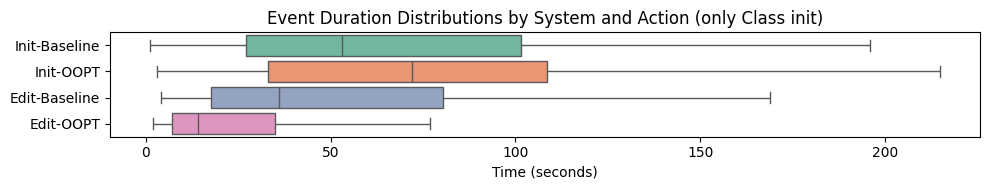

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 데이터 불러오기 ---
df = pd.read_csv("csv/all_participants_event_durations_.csv")

# 필요한 label만 추출
target_labels = ["Init-OOPT", "Init-Baseline", "Edit-OOPT", "Edit-Baseline"]
df = df[df["label"].isin(target_labels)]

# label 순서 지정
label_order = ["Init-Baseline", "Init-OOPT", "Edit-Baseline", "Edit-OOPT"]

# --- 시각화 ---
plt.figure(figsize=(10, 2))

# x축 = delta_sec, y축 = label
sns.boxplot(
    data=df,
    x="delta_sec",
    y="label",
    order=label_order,
    orient="h",
    showfliers=False,  # 극단치 표시 안할 경우
    palette="Set2"
)

# 분포 모양을 좀 더 보고 싶으면 violinplot 추가 (투명도)
# sns.violinplot(
#     data=df,
#     x="delta_sec",
#     y="label",
#     order=label_order,
#     orient="h",
#     inner=None,
#     color="0.9",
#     alpha=0.3
# )

plt.xlabel("Time (seconds)")
plt.ylabel("")
plt.title("Event Duration Distributions by System and Action (only Class init)")
plt.tight_layout()
plt.show()


## Logging에서 에러: class modal읠 띄우고, "Create Instance"라는 버튼을 누르는 로깅은 진행하지 않음. 
## 이를 수동으로 기록해야할듯...

P4,OOPT,Init-OOPT,class_detail_opened,api.generate_scene_graph_to_text.started,2025-08-25 14:11:31,2025-08-25 14:15:06,215.0

—> 215 - 30 ‎ = 185

P7,OOPT,Init-OOPT,class_detail_opened,instance.create_from_class.started,2025-08-25 11:12:35,2025-08-25 11:14:18,103.0

—> 103 -10 ‎ = 93

P10,OOPT,Init-OOPT,class_detail_opened,instance.create_from_class.started,2025-08-25 09:54:46,2025-08-25 09:56:57,131.0

—> 131 - 10 ‎ = 121

